In [1]:
from plantcv import plantcv as pcv
import matplotlib 

In [2]:
matplotlib.rcParams["figure.figsize"] = [8,8]


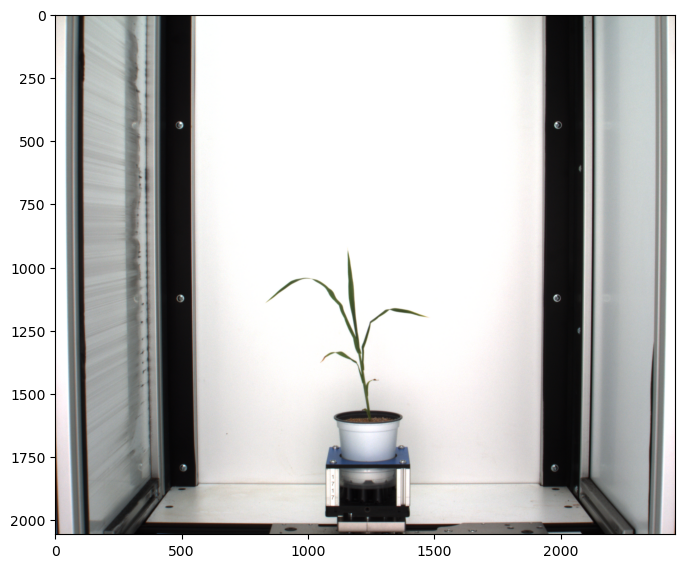

In [3]:
class options:
    def __init__(self):        
        self.image = "sorghum_images/VIS_SV_0_z1_h1_g0_e65_v500_216437_2016-06-28-21-39-31_Fa016AC031775.png" 
        self.image = "small_subset/VIS_SV_0_z1_h1_g0_e65_v500_216437_2016-06-28-21-39-31_Fa016AC031775.png" 
        self.debug = "plot"
        self.writeimg = False
        self.result = "results.txt"
        self.outdir = "."

args = options()
pcv.params.outdir = args.outdir
pcv.params.debug = args.debug
# Read the image 
img, path, filename = pcv.readimage(filename=args.image)

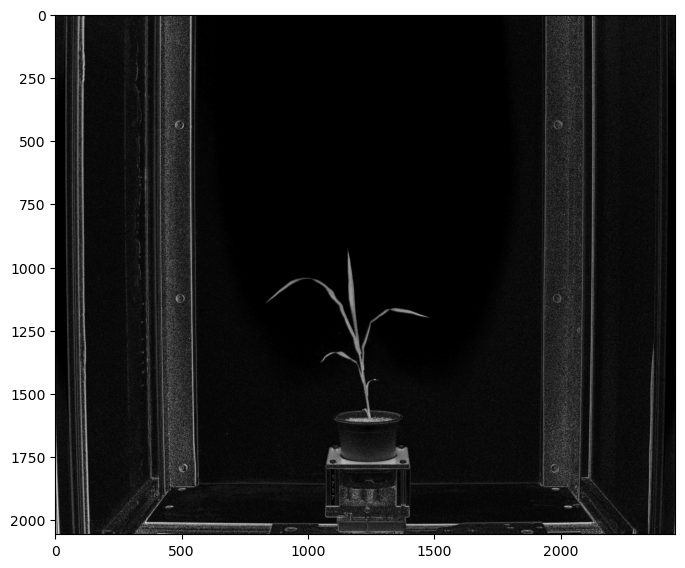

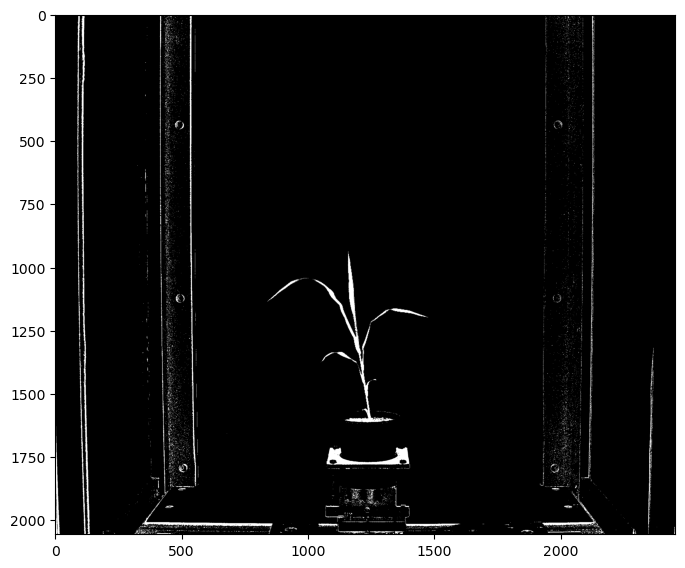

In [4]:
####################################################
### SEGMENTATION 
# Saturation channel
s = pcv.rgb2gray_hsv(rgb_img=img, channel='s')
s_thresh = pcv.threshold.binary(gray_img=s, threshold=80, max_value=255, object_type='light')



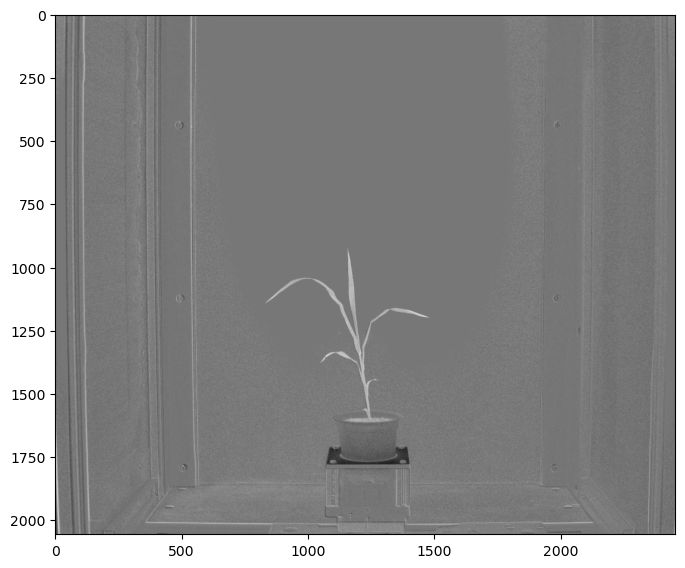

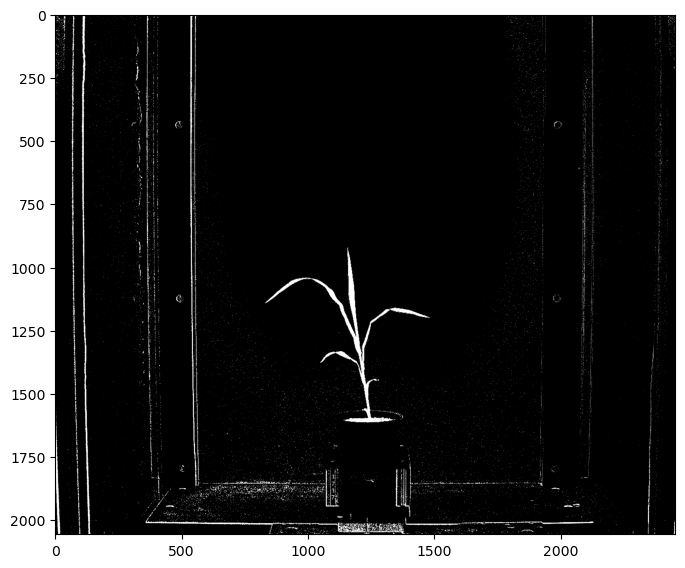

In [5]:
# Blue-yellow channel 
b = pcv.rgb2gray_lab(rgb_img=img, channel='b')
b_thresh = pcv.threshold.binary(gray_img=b, threshold=134, max_value=255, object_type='light')



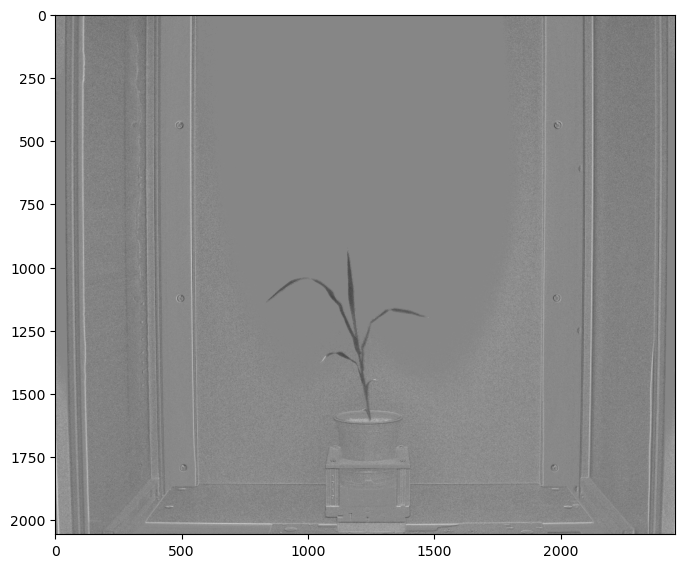

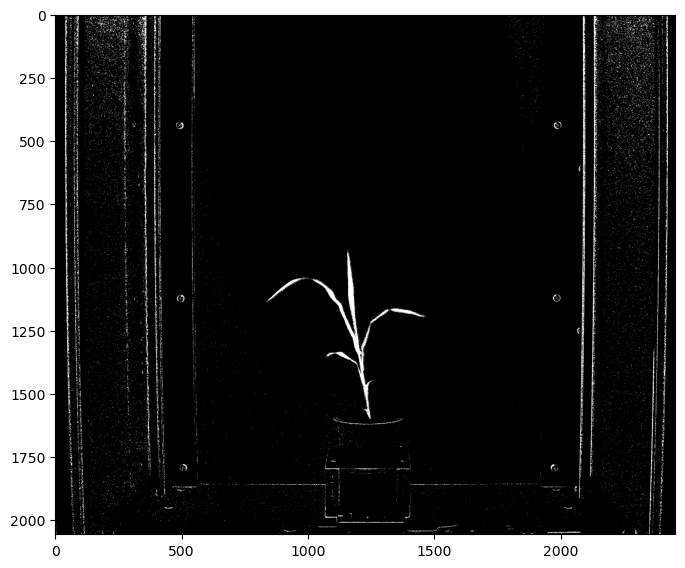

In [6]:
# Green-magenta
a = pcv.rgb2gray_lab(rgb_img=img, channel='a')
a_thresh = pcv.threshold.binary(gray_img=a, threshold=122, max_value=255, object_type='dark')



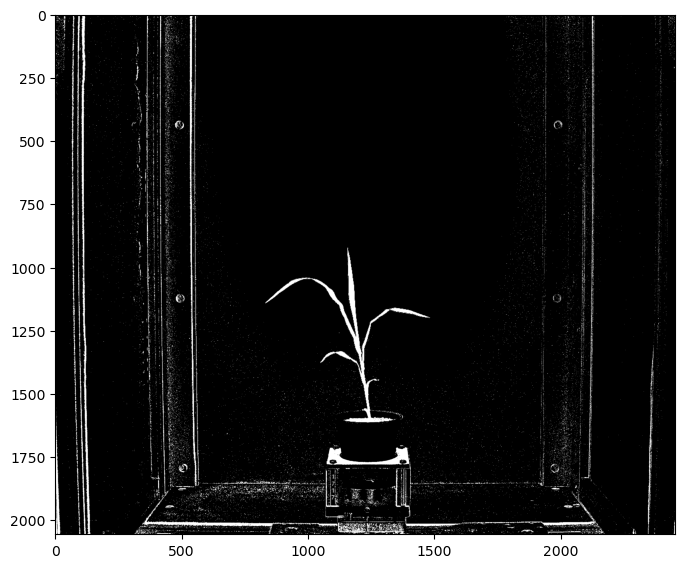

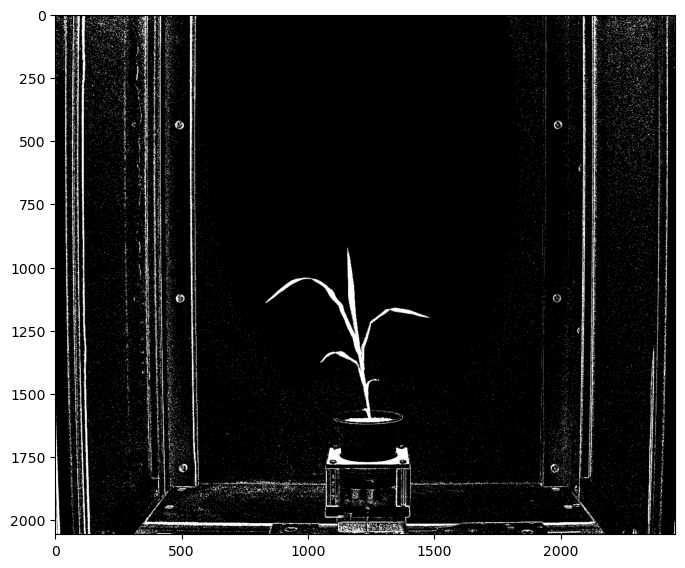

In [7]:
# Combine 
bs = pcv.logical_or(bin_img1=s_thresh, bin_img2=b_thresh)
bsa = pcv.logical_or(bin_img1=bs, bin_img2=a_thresh)



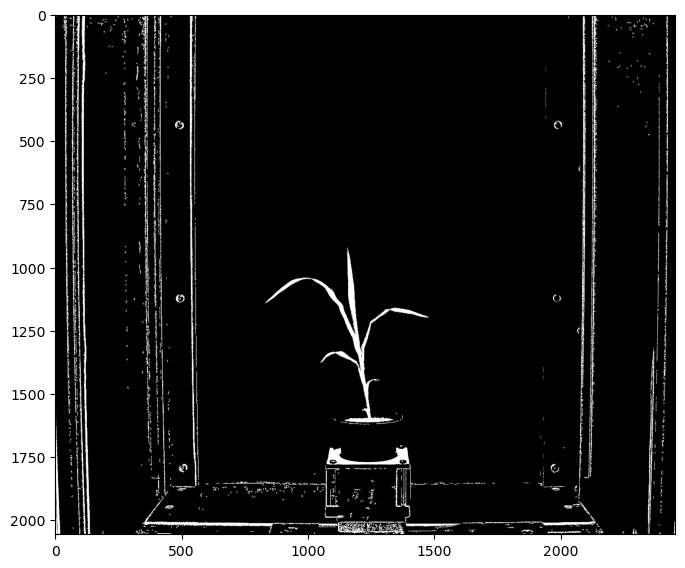

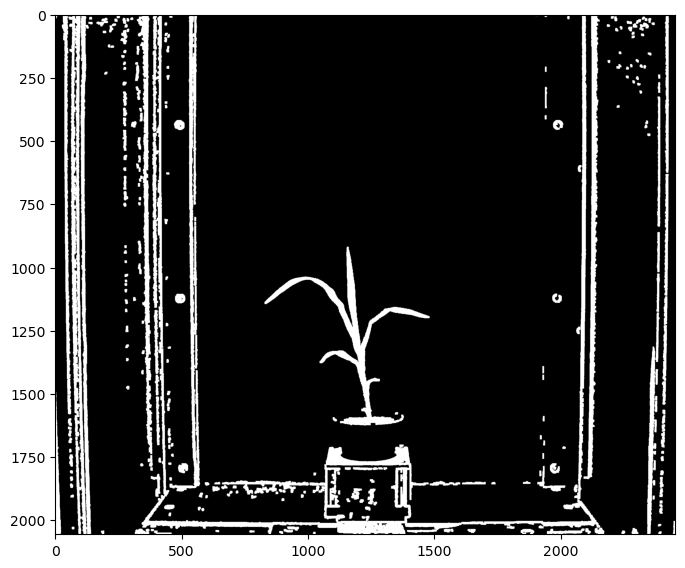

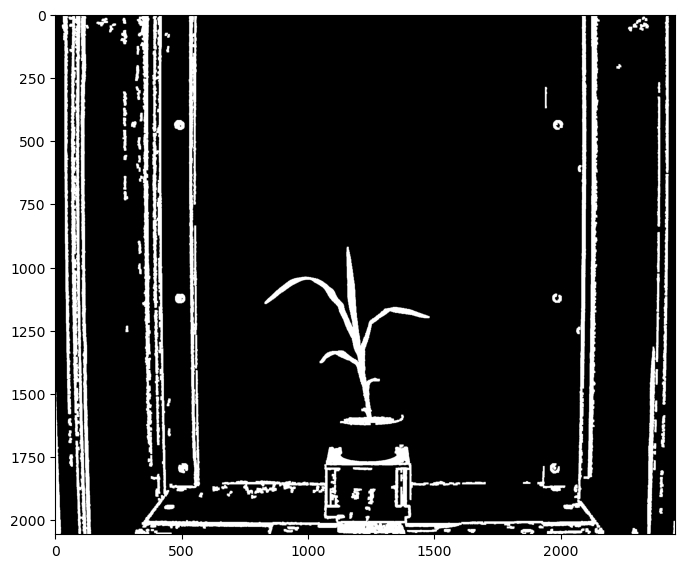

In [8]:
# Rough cleaning 
bsa_fill1 = pcv.fill(bin_img=bsa, size=15) # Fill small noise
bsa_fill2 = pcv.dilate(gray_img=bsa_fill1, ksize=3, i=3) # Dilate to join objects
bsa_fill3 = pcv.fill(bin_img=bsa_fill2, size=250) # Fill large noise 



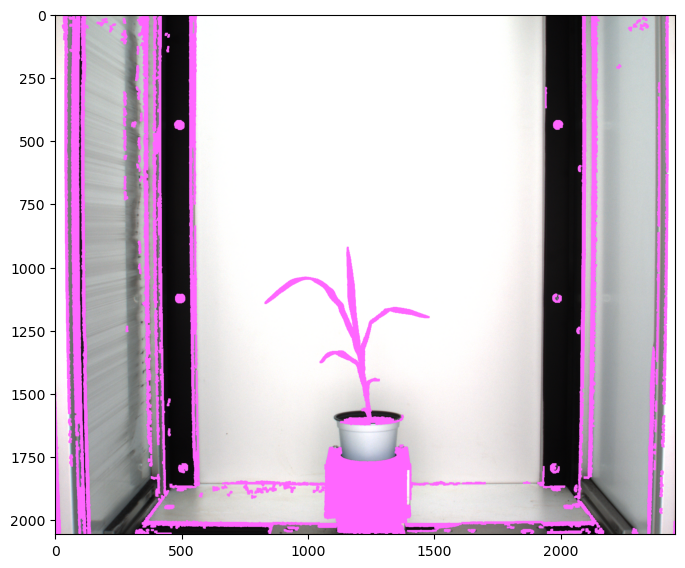

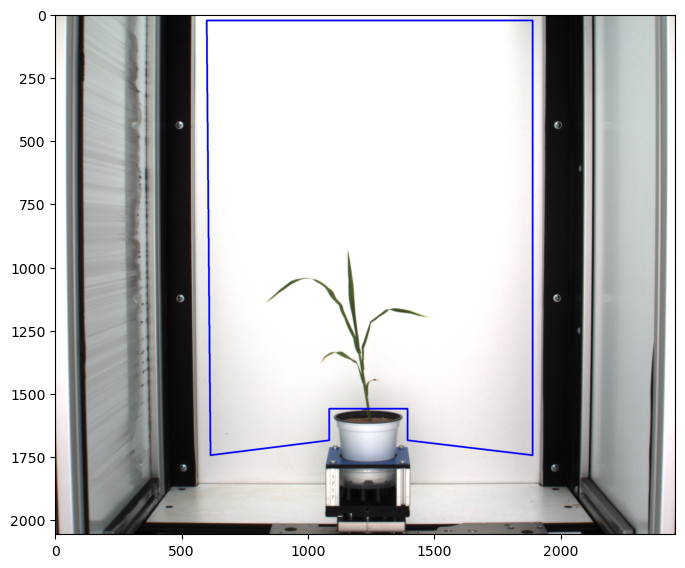

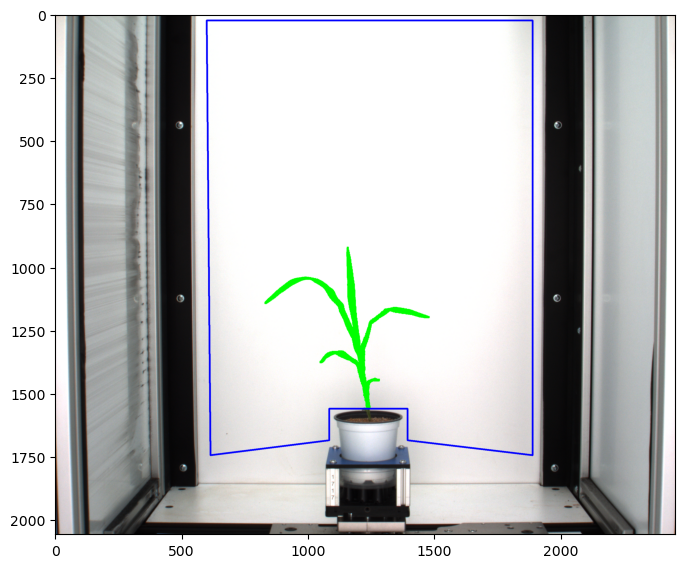

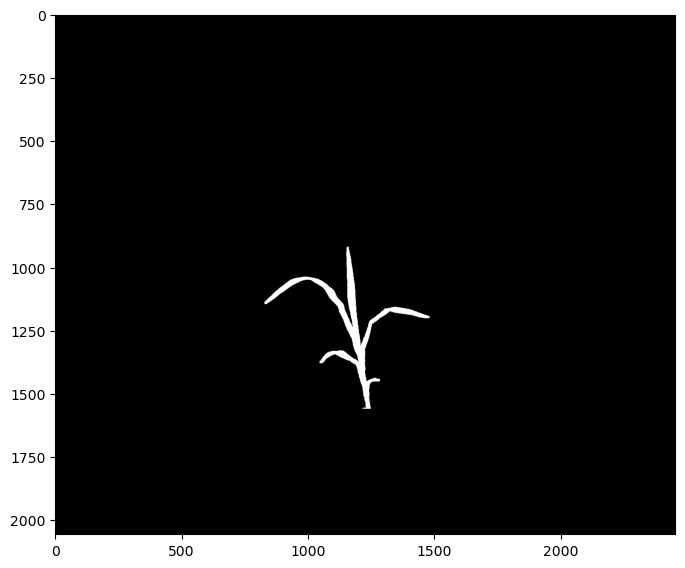

In [9]:
# USE CUSTOM ROI to avoid soil while being aggressive with plant pixels kept 
id_objects, obj_hierarchy = pcv.find_objects(img=img, mask=bsa_fill3) # Identify contours 
roi_custom, roi_hier_custom = pcv.roi.custom(img=img, vertices=[[1085,1560], [1395,1560], [1395,1685], [1890 , 1744], [1890 , 25], [600 , 25], [615 , 1744], [1085,1685]]) # Make a custom polygon ROI
roi_objects, hierarchy, kept_mask, obj_area = pcv.roi_objects(img, roi_custom, roi_hier_custom, id_objects, obj_hierarchy, 'cutto') 



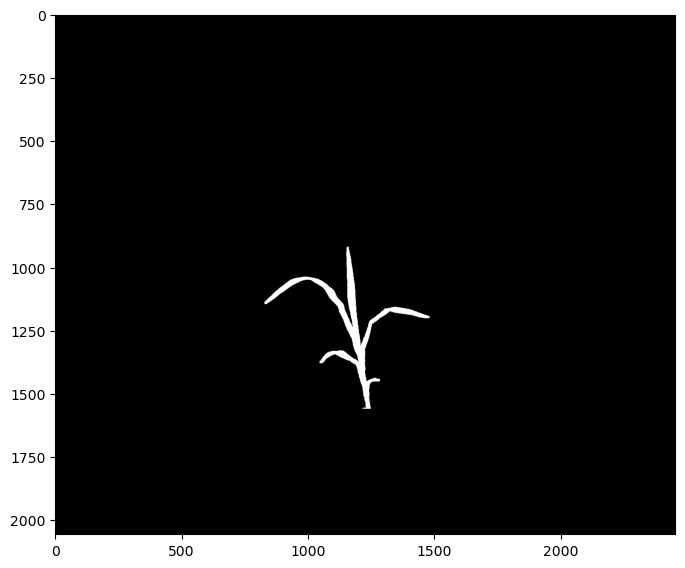

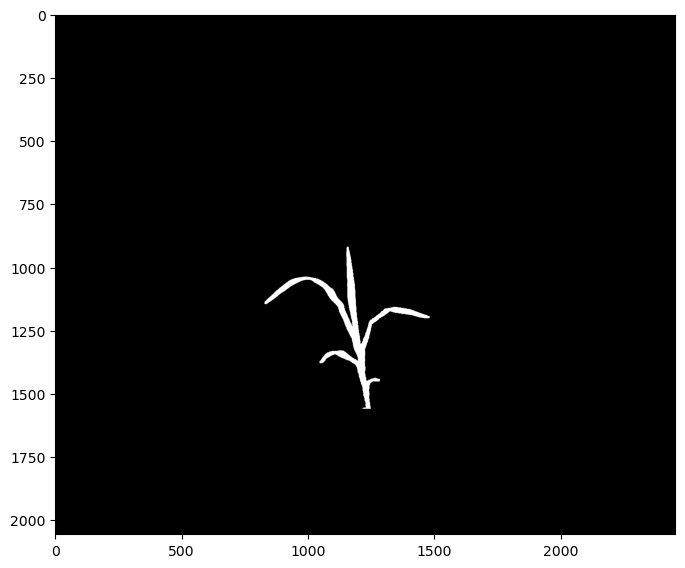

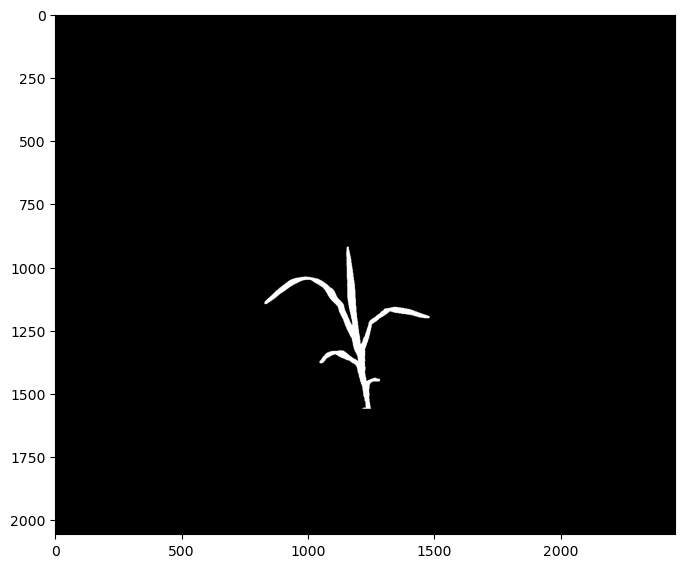

In [10]:
# Clean up and fill any gaps within plant mask 
filled_mask1 = pcv.fill(bin_img=kept_mask, size=350)
filled_mask2 = pcv.closing(gray_img=filled_mask1)
filled_mask3 = pcv.fill_holes(filled_mask2)



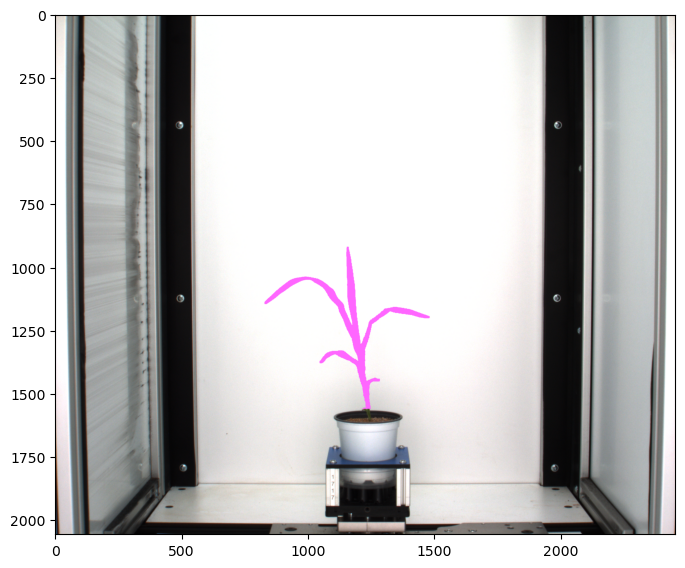

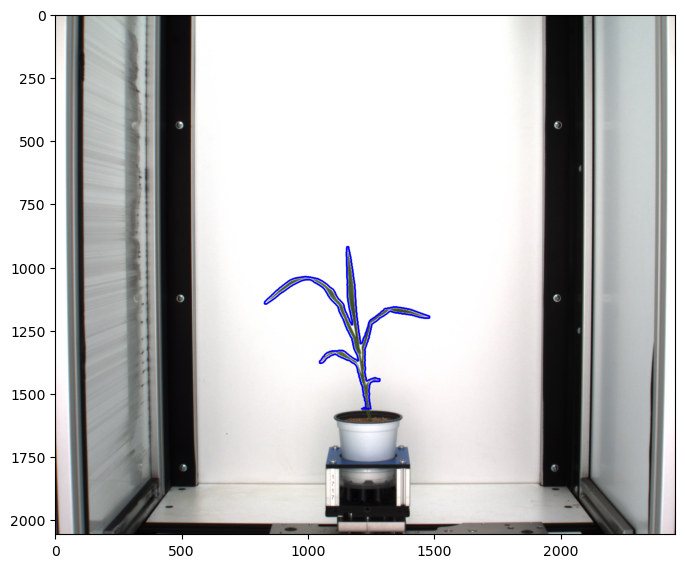

In [11]:
# Identify final plant mask and combine objects
id_objects, obj_hierarchy = pcv.find_objects(img=img, mask=filled_mask3)
obj, mask = pcv.object_composition(img=img, contours=id_objects, hierarchy=obj_hierarchy)

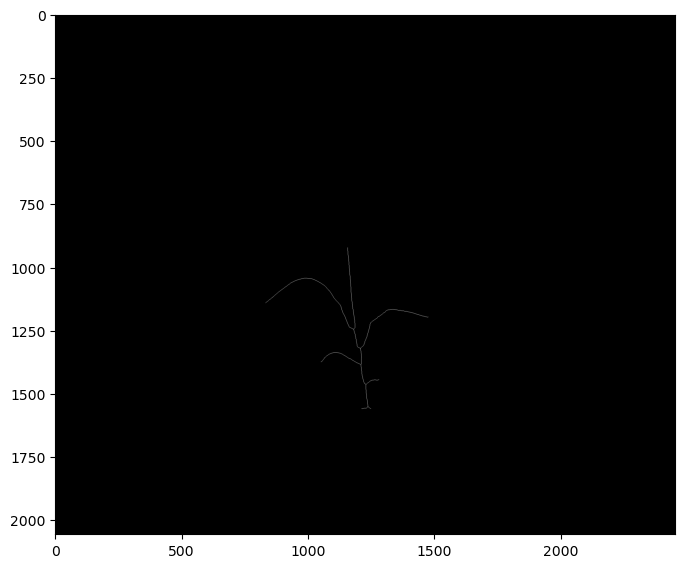

In [12]:
####################################################
### MORPHOLOGY WORKFLOW PART
pcv.params.text_size = 1.5
pcv.params.text_thickness = 5
pcv.params.line_thickness = 15
skel = pcv.morphology.skeletonize(mask=mask)


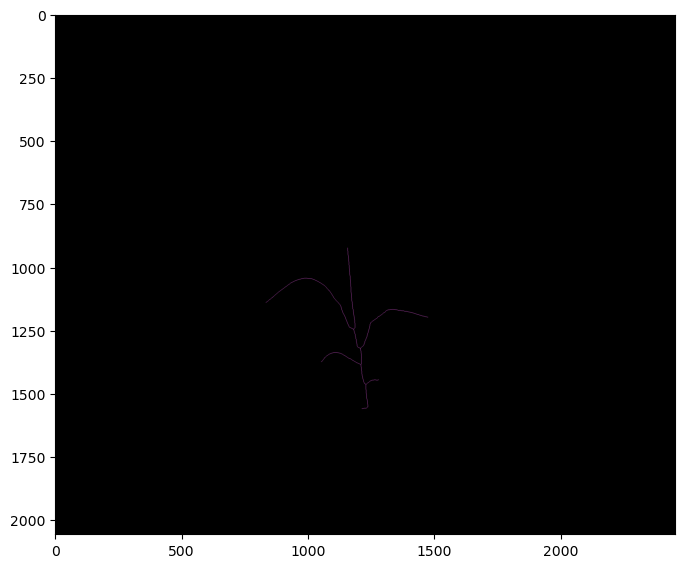

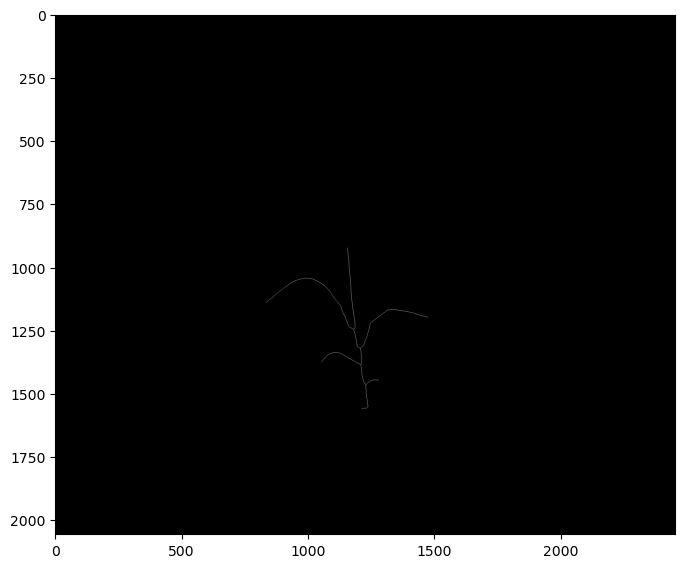

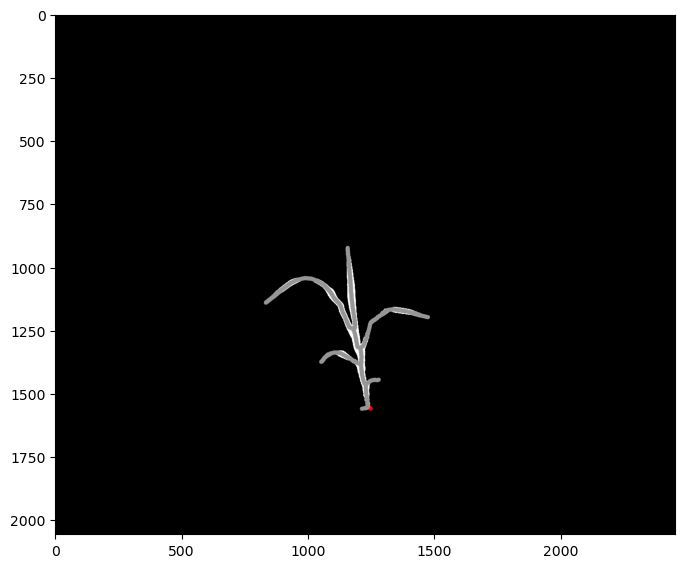

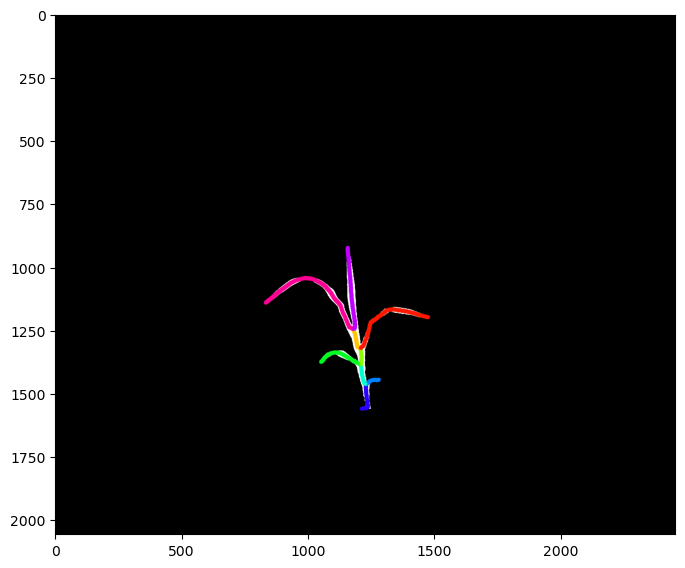

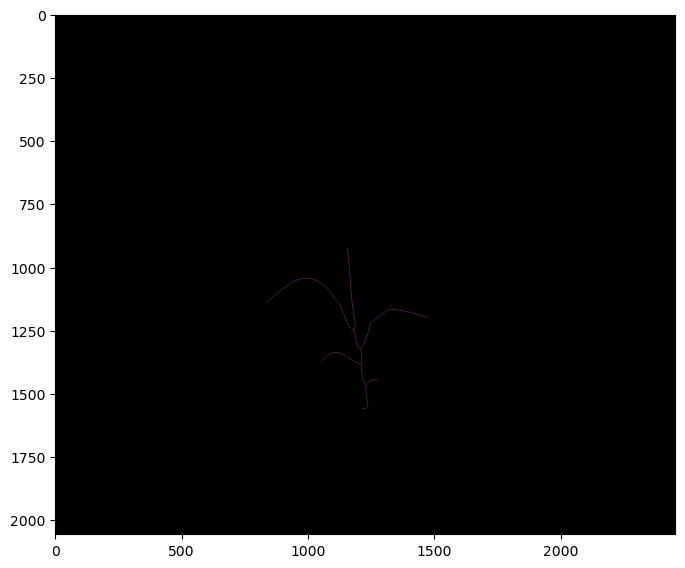

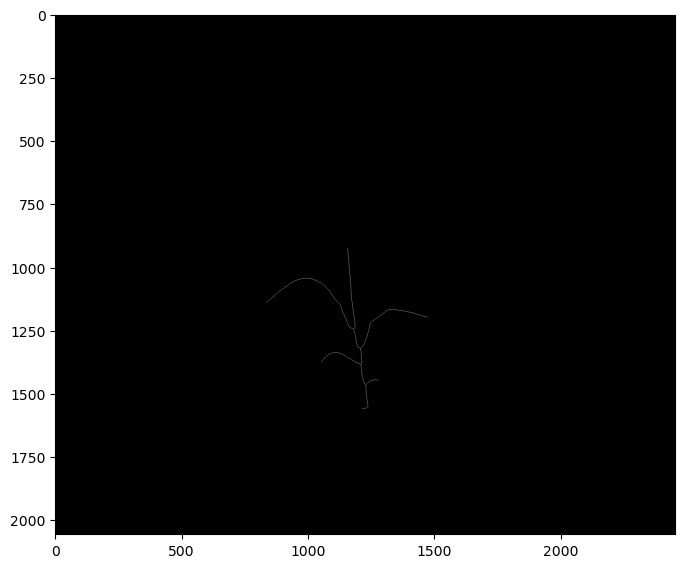

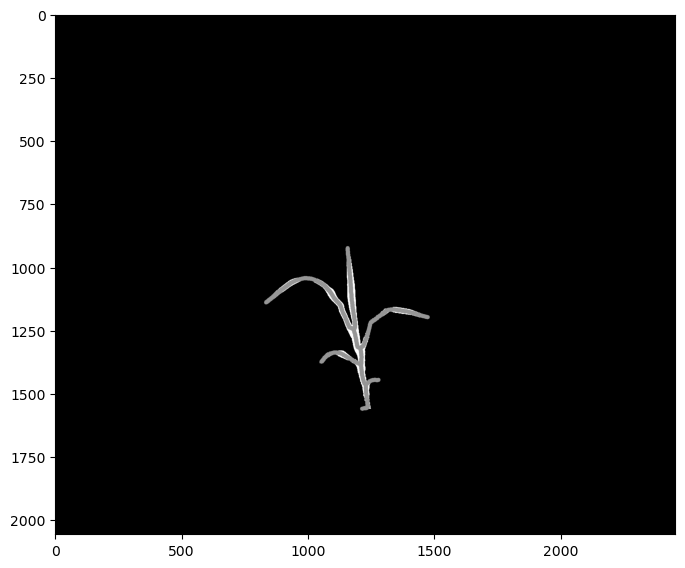

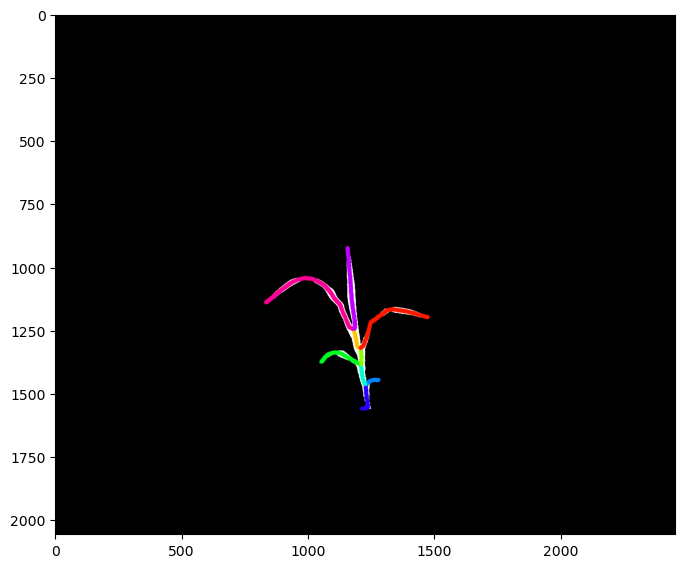

In [13]:
# Prune back barbs off the skeleton
pruned, segmented_img, segment_objects = pcv.morphology.prune(skel_img=skel, size=30, mask=mask)
pruned, segmented_img, segment_objects = pcv.morphology.prune(skel_img=pruned, size=3, mask=mask)


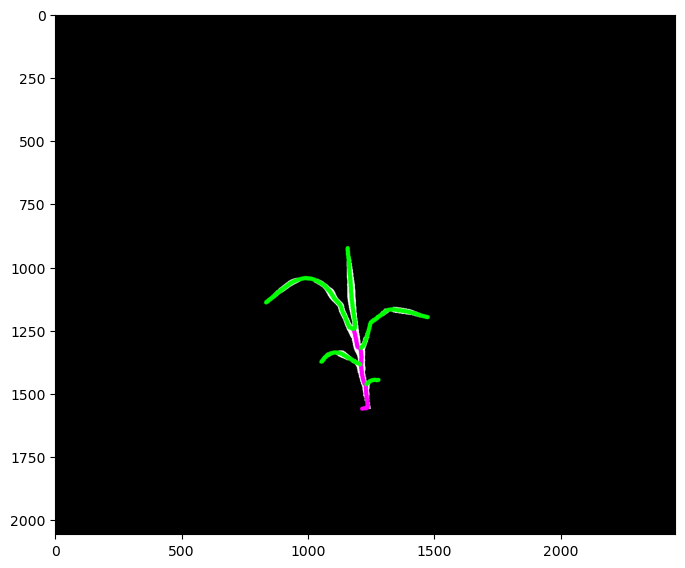

In [14]:
# Sort segments into leaf and stem 
leaf_objects, other_objects = pcv.morphology.segment_sort(skel_img=pruned, objects=segment_objects, mask=mask)


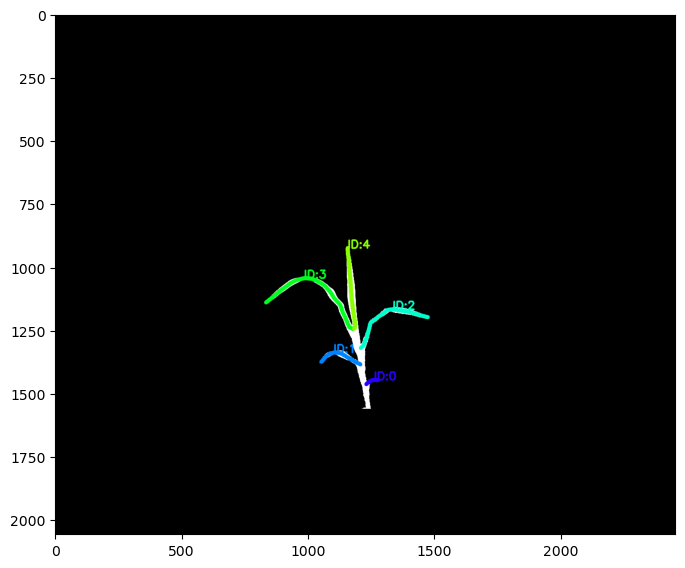

In [15]:
# Identify segments     
segmented_img, labeled_id_img = pcv.morphology.segment_id(skel_img=pruned, objects=leaf_objects, mask=mask)


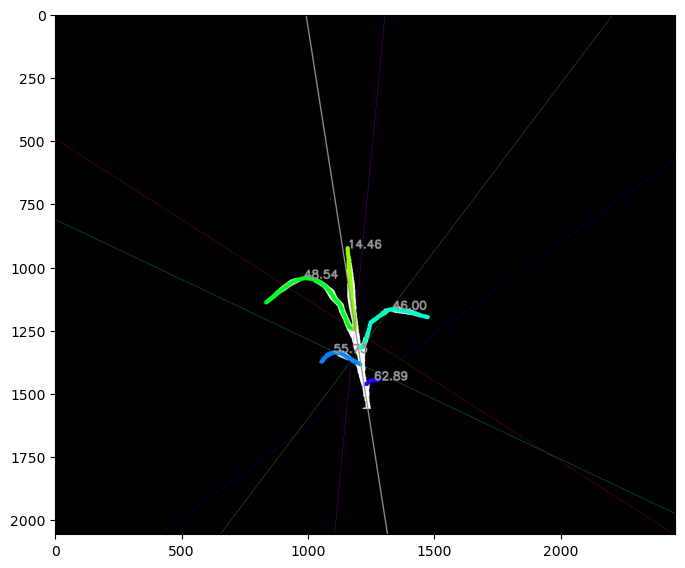

In [16]:
# Extract relative leaf angles 
labeled_angle_img = pcv.morphology.segment_insertion_angle(skel_img=pruned, segmented_img=segmented_img, leaf_objects=leaf_objects, stem_objects=other_objects, size=22)


**Other potential morphological measurements** 

There are many other functions that extract data from within the morphology sub-package of PlantCV. For our purposes, we are most interested in the relative angle between each leaf and the stem which we measure with `plantcv.morphology.segment_insertion_angle`. However, the following cells show some of the other traits that we are able to measure from images that can be succesfully sorted into primary and secondary segments. 

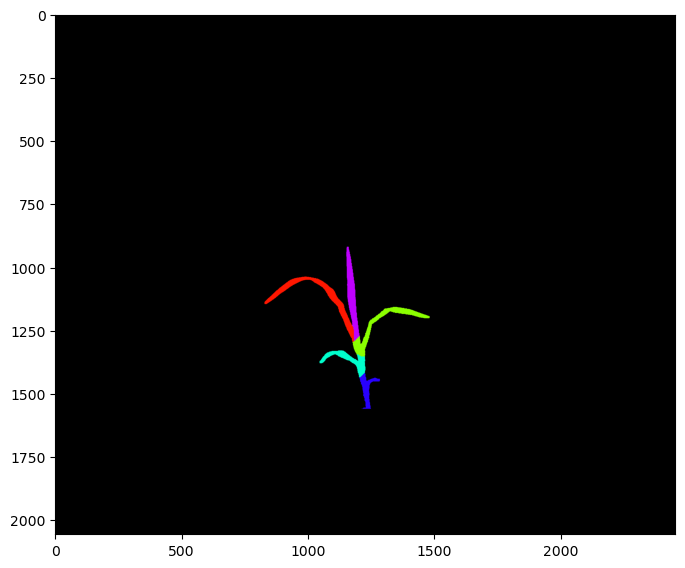

In [17]:
# Fill in leaf objects and collect leaf area information 

filled_img = pcv.morphology.fill_segments(mask=mask, objects=leaf_objects)


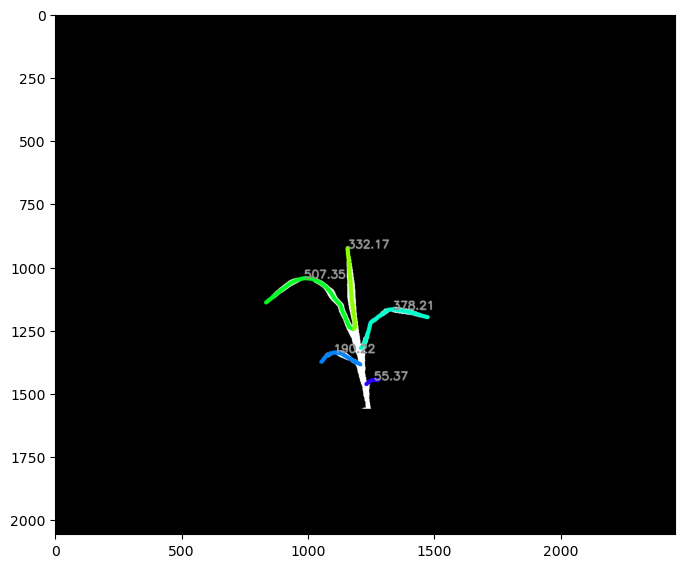

In [18]:
# Measure path lengths of segments     

labeled_img2 = pcv.morphology.segment_path_length(segmented_img=segmented_img, objects=leaf_objects)


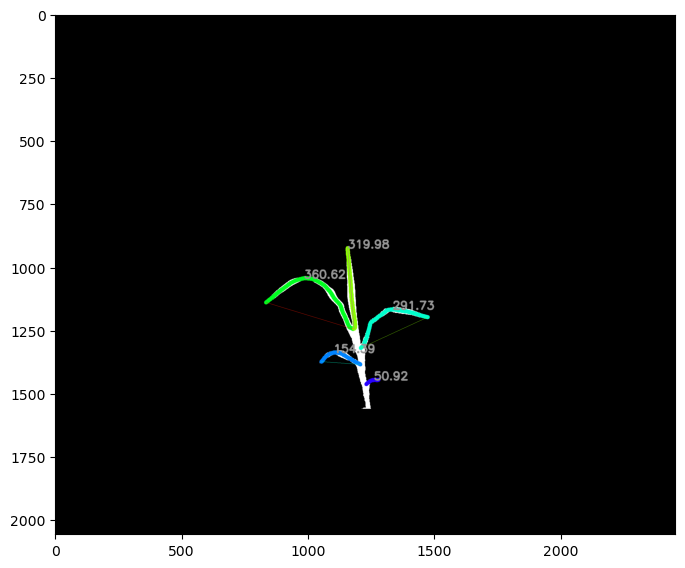

In [19]:
# Measure the euclidean (tip to tip distance) of each leaf 

labeled_img3 = pcv.morphology.segment_euclidean_length(segmented_img=segmented_img, objects=leaf_objects)


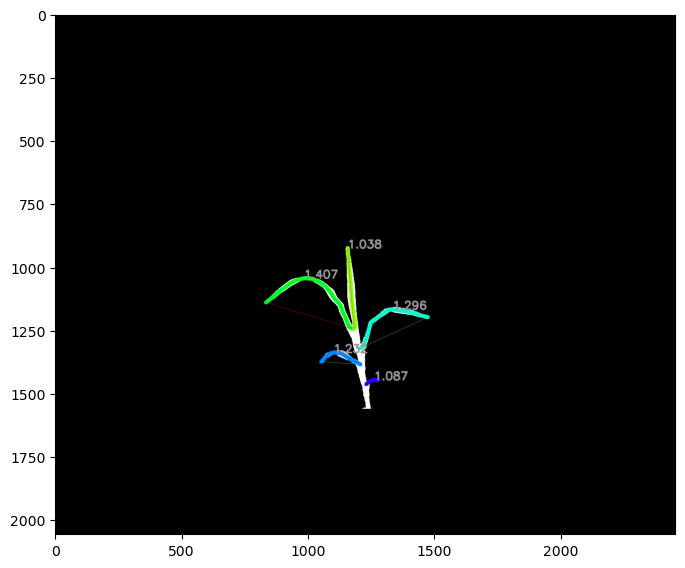

In [20]:
# Measure the curvature of each leaf (Values closer to 1 indicate that a segment is a straight line while 
# larger values indicate the segment has more curvature)

labeled_img4 = pcv.morphology.segment_curvature(segmented_img=segmented_img, objects=leaf_objects)


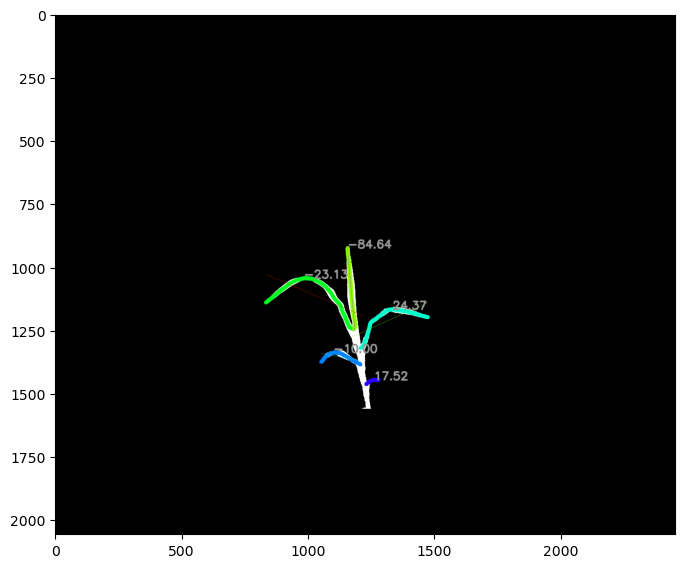

In [21]:
# Measure absolute leaf angles (angle of linear regression line fit to each leaf object)
# Note: negative values signify leaves to the left of the stem, 
# positive values signify leaves to the right of the stem

labeled_img5 = pcv.morphology.segment_angle(segmented_img=segmented_img, objects=leaf_objects)


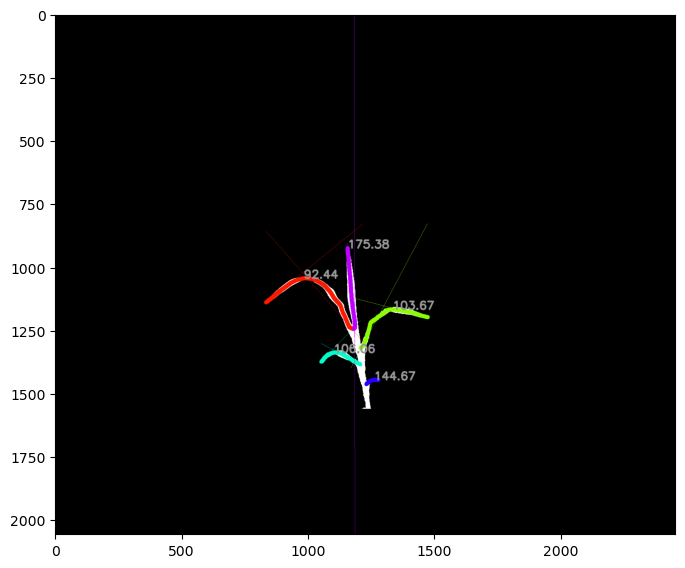

In [22]:
# Measure leaf curvature in degrees 
labeled_img6 = pcv.morphology.segment_tangent_angle(segmented_img=segmented_img, objects=leaf_objects, size=35)


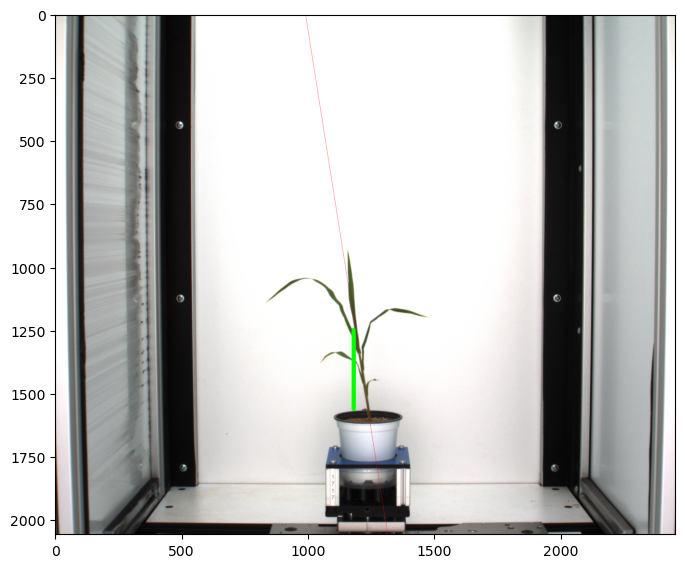

In [23]:
# Analyze stem characteristics like stem angle and length 
stem_img = pcv.morphology.analyze_stem(rgb_img=img, stem_objects=other_objects)

**Print results out to file for downsteam analysis**

In [24]:
pcv.print_results(filename=args.result)